# Manipulation des données de la base Neo4J d'Euclid

Ce notebook a pour but d'extraire les données Neo4J du projet Euclid (ou d'une base de données test), et d'y appliquer un algorithme de clustering. Il calcule également des mesures sur le graphe (ici les mesures d'inertie et de *silhouette score*) afin d'estimer au mieux le nombre $k$ optimal de clusters. Ces mesures sont aussi affichées et peuvent être sauvegardées.



#### Ici, nous utilisons comme méthode de clustering le *partitionnement spectral*.

In [1]:
import numpy as np
import pickle as pkl

from neo4j import GraphDatabase

from scipy.sparse import csgraph
from sklearn.cluster import KMeans

In [2]:
def remove_names_NS(node_names, namespaces):
    """
    Fonction pour retirer dans la requête les noeuds du namespace
    qui commencent par les chaînes contenues dans la liste
    """
    out_cond = 'NOT ('
    out_cond += ") AND NOT (".join(" OR ".join(f'{node_name}.fullname =~ "{ns}.*"' for ns in namespaces) for node_name in node_names)
    out_cond += ')'
    
    return out_cond

### Si test

In [ ]:
nodeType, relType, version, use_weights = "Node", "LINKED_TO", "V1", False

### Sinon

In [3]:
#Type des noeuds et des relations du sous-graphe voulu
nodeType, relType = "Type", "USE_TYPE"

#Si on veut combiner des relations (CONTAINS et USE_NS par exemple)
#nodeType = "CONTAINS|USE_NS"

#Utilisation de poids, sinon une relation vaut 1
#Le sous-graphe avec la relation CONTAINS est un arbre, on ne sert donc pas de la variable pour elle
use_weights = True

version = "V4"

 Namespaces à enlever selon la version :
 
* V1 -> Aucune restriction
* V2 -> Pas de namespace lié à la DPD
* V3 -> V2 + pas de namespace lié à PRO
* V4 -> V3 + pas de namespace lié à INTERFACES

In [4]:
if version == "V1":
    remove_ns = []
elif version == "V2":
    remove_ns = ['dpd']
elif version == "V3":
    remove_ns = ['dpd','pro']
elif version == "V4":
    remove_ns = ['dpd','pro','interfaces']

---


In [5]:
str_weight = 'W' if use_weights and relType in  {'USE_NS', 'USE_TYPE'} else ''
graph_suffix = f"{relType}{version}{str_weight}"

In [6]:
#True si les types viennent d'un même namespace
#False sinon
type_same_ns = False

cond = ""

if version not in {"V0","V1"}:
    if nodeType == 'Type':
        nodeNames = ['ns'] if type_same_ns else ['ns','ns2'] 
    else:
        nodeNames = ['n1','n2']
    
    cond = f"WHERE {remove_names_NS(nodeNames,remove_ns)}"

In [7]:
def query_start(d="",same_ns=True):
    """
    Décrit le début de la requête Cypher sur le sous-graphe Neo4J désiré
    
    d: Direction de la relation
    same_ns: indique si les noeuds de type Type doivent faire partie du même namespace
    """
    q = f'(n1:{nodeType}){"<-" if d == "l" else "-"}[r:{relType}]{"->" if d == "r" else "-"}(n2:{nodeType})'  
    
    if nodeType == "Type":
        q = f"(ns:Namespace)<-[:DECLARED_IN]-{q}-[:DECLARED_IN]->({'ns' if same_ns else 'ns2:Namespace'})"
        
    q = f'MATCH {q} {cond}'
    
    return q

In [8]:
#Nom du paramètre de poids selon la relation
q_poids = lambda: "n_times" if relType == "USE_TYPE" else "nb_use"

#Nom du paramètre de nom selon la relation
q_name = lambda: "fullname" if nodeType == "Namespace" else "name"

#Sous forme de fonctions lambda pour pouvoir changer facilement de relations

In [9]:
query_start(same_ns=type_same_ns), q_poids(), q_name(), cond

('MATCH (ns:Namespace)<-[:DECLARED_IN]-(n1:Type)-[r:USE_TYPE]-(n2:Type)-[:DECLARED_IN]->(ns2:Namespace) WHERE NOT (ns.fullname =~ "dpd.*" OR ns.fullname =~ "pro.*" OR ns.fullname =~ "interfaces.*") AND NOT (ns2.fullname =~ "dpd.*" OR ns2.fullname =~ "pro.*" OR ns2.fullname =~ "interfaces.*")',
 'n_times',
 'name',
 'WHERE NOT (ns.fullname =~ "dpd.*" OR ns.fullname =~ "pro.*" OR ns.fullname =~ "interfaces.*") AND NOT (ns2.fullname =~ "dpd.*" OR ns2.fullname =~ "pro.*" OR ns2.fullname =~ "interfaces.*")')

---

### Base Euclid

In [10]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j","euclid"))
session = driver.session()

##### Requête pour obtenir le nombre de noeuds du graphe (ne compte pas les noeuds liés à aucune relation)

In [11]:
query_nbnoeuds = f'{query_start(same_ns=type_same_ns)} RETURN COUNT(DISTINCT n1) as nb'

### Base de test

In [ ]:
driverTest = GraphDatabase.driver("bolt://localhost:11007", auth=("neo4j","0"))
session = driverTest.session()

##### Requête pour obtenir le nombre de noeuds du graphe (ne compte pas les noeuds liés à aucune relation)

In [ ]:
query_nbnoeuds = "MATCH (:Node) RETURN COUNT(*) as nb"

-------------

### Récupération du nombre de noeuds
Ne compte pas les noeuds qui ne sont pas liés par une relation `relType`

In [12]:
res = session.run(query_nbnoeuds)
for r in res: nbnoeuds = r["nb"]

In [13]:
nbnoeuds

578

-----------

### Récupération du poids maximal de la relation concernée

In [14]:
query = f'{query_start(same_ns=type_same_ns)} RETURN MAX(TOINTEGER(r.{q_poids()})) AS max_poids'
res = session.run(query)

In [15]:
for r in res: max_poids = r['max_poids']

In [16]:
max_poids

6

### Calcul de la matrice laplacienne L

In [17]:
ids_dict = dict()

def new_node_id(id):
    """
    Fonction pour générer de nouveaux IDs 
    pour les noeuds à partir de leur ID en Neo4j 
    """
    id_num = len(ids_dict)
    if id not in ids_dict:
        ids_dict[id] = id_num
        id_num += 1
    return ids_dict[id]

def calc_L(query,use_weights=False):
    """
    Calcule la matrice laplacienne L et retourne aussi
    les matrices des degrés D et la matrice d'adjacence A
    mise à jour lors du calcul
    """
    
    A = np.zeros((nbnoeuds,nbnoeuds))
    
    res = session.run(query)
    
    for r in res:
        id1, id2 = new_node_id(r["id1"]), new_node_id(r["id2"])
        #print(r["poids"])
        if use_weights and relType in {"USE_NS","USE_TYPE"}:
            #Les relations optionnelles n'ont que 10% de leur poids
            poids = (r["poids"]*(0.1 if r['opt'] == "yes" else 1)+1)/(max_poids+1)
        else:
            poids = 1

        #Ajout dans la matrice d'adjacence
        A[id1,id2] = poids
                
    #Création de la matrice laplacienne
    L = csgraph.laplacian(A, normed=True)  

    return L

----------

#### Calcul de la matrice pour la relation donnée

In [18]:
query = f'{query_start(same_ns=type_same_ns)} RETURN ID(n1) AS id1, ID(n2) AS id2, TOINTEGER(r.{q_poids()}) AS poids, r.optional as opt'
L = calc_L(query,use_weights=use_weights)

#### Tentative de combinaison des résultats des relations **USE_NS** et **CONTAINS**

In [ ]:
relType = "USE_NS"
query = f'{query_start("r",type_same_ns)} RETURN ID(n1) AS id1, ID(n2) AS id2, TOINTEGER(r.{q_poids()}) AS poids, r.optional as opt'
L = calc_L(query,use_weights=use_weights)

relType = "CONTAINS"
query = f'{query_start(same_ns=type_same_ns)} RETURN ID(n1) AS id1, ID(n2) AS id2, TOINTEGER(r.{q_poids()}) AS poids'
L2 = calc_L(query)

In [ ]:
wL = 0.75
wL2 = 1-wL

L = wL*L + wL2*L2

#On a besoin de faire ça aussi pour D
#pour pouvoir normaliser L
D = wL*D + wL2*D2

#### Calcul des valeurs propres et des vecteurs propres

In [19]:
vp_norm, vectp_norm = np.linalg.eigh(L)

#### Si on veut sauvegarder les valeurs propres

In [20]:
pkl.dump(vp_norm, open(f"VP{graph_suffix}.pkl","wb"))

----------------

### Calcul du KMeans sur la matrice laplacienne

In [ ]:
k = 13
kmeans = KMeans(n_clusters=k).fit(vectp_norm[:,:k])

In [ ]:
kmeans.inertia_, kmeans.labels_

-----------------------------

## Calcul des mesures du graphe (inertie et silhouette score)

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [22]:
max_k = min(nbnoeuds,81)
nb_iter = 3
inertias = []
silhs = []

#Moyenne de n itérations de calculs différents de KMeans de 2 à 80 max
for i in range(nb_iter):
    print(f"ITERATION {i+1}/{nb_iter}")
    inertia = []
    silh = []
    for k in range(2,max_k):
        if k%10 == 0: print(f"{k}/{max_k-1}")
        kmeans = KMeans(n_clusters=k).fit(vectp_norm[:,:k])
        inertia.append(kmeans.inertia_)
        silh.append(silhouette_score(vectp_norm[:,:k], kmeans.labels_))
    if (max_k-1) % 10 != 0: print(f"{max_k-1}/{max_k-1}")
    inertias.append(inertia)
    silhs.append(silh)

avg_inertia = np.array(inertias).mean(0)
avg_silh = np.array(silhs).mean(0)

ITERATION 1/3
10/80
20/80
30/80
40/80
50/80
60/80
70/80
80/80
ITERATION 2/3
10/80
20/80
30/80
40/80
50/80
60/80
70/80
80/80
ITERATION 3/3
10/80
20/80
30/80
40/80
50/80
60/80
70/80
80/80


#### Sauvegarde des valeurs de l'inertie et du silhouette score

In [23]:
pkl.dump(avg_inertia, open(f'inertia{graph_suffix}.pkl','wb'))
pkl.dump(avg_silh, open(f"silh{graph_suffix}.pkl","wb"))

## Représentations graphiques du graphe

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer

plt.rcParams['figure.figsize'] = (15,10)

In [31]:
def get_graph_info(offset_left=0,offset_right=0):
    """
    Fonction pour définir le suffixe des figures matplotlib
    """
    str_zoom = "zoom" if offset_left + offset_right != 0 else ""
    str_ns = " ".join(list(map(lambda s: "no "+s, remove_ns)))

    if str_zoom + str_ns != "":
        graph_info = f'({str_ns}{", " if str_ns != "" and str_zoom != "" else ""}{str_zoom})'
    else:
        graph_info = ""
        
    return graph_info

### Evolution de l'inertie selon la valeur de k

Text(0.5, 1.0, "Evolution de l'inertie du KMeans sur le graphe USE_TYPE (no dpd no pro no interfaces)")

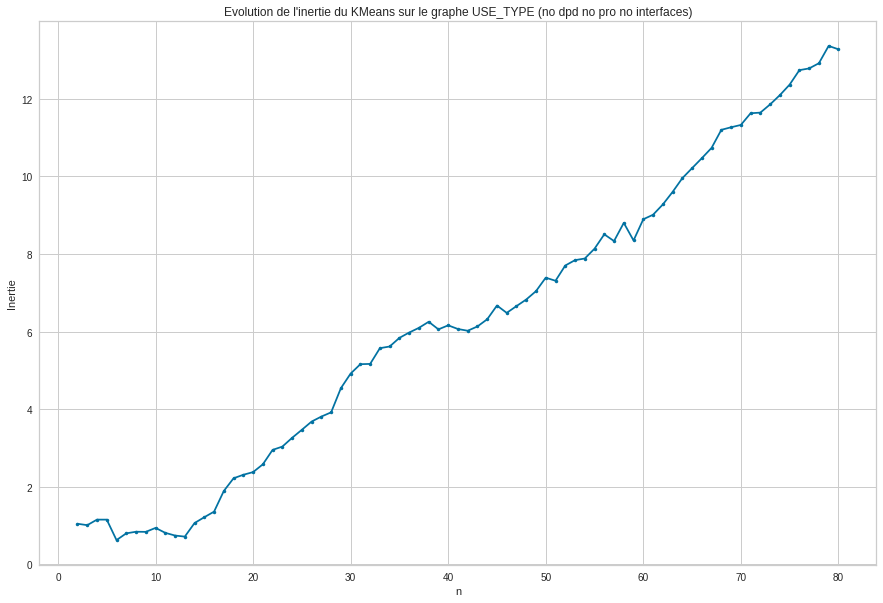

In [34]:
offset_left = 0
offset_right = 0
plt.plot(range(2+offset_left,max_k-offset_right), avg_inertia[offset_left:(-offset_right if offset_right>0 else nbnoeuds)], marker=".")
plt.xlabel("n")
plt.ylabel("Inertie")
plt.title(f"Evolution de l'inertie du KMeans sur le graphe {relType} {get_graph_info(offset_left,offset_right)}")

#plt.savefig(f"inertie{graph_suffix}{"zoom" if offset_left+offset_right>0 else ""}.png")

### Evolution du silhouette score en fonction de k

Text(0.5, 1.0, 'Evolution du sihouette score du KMeans sur le graphe USE_TYPE (no dpd no pro no interfaces)')

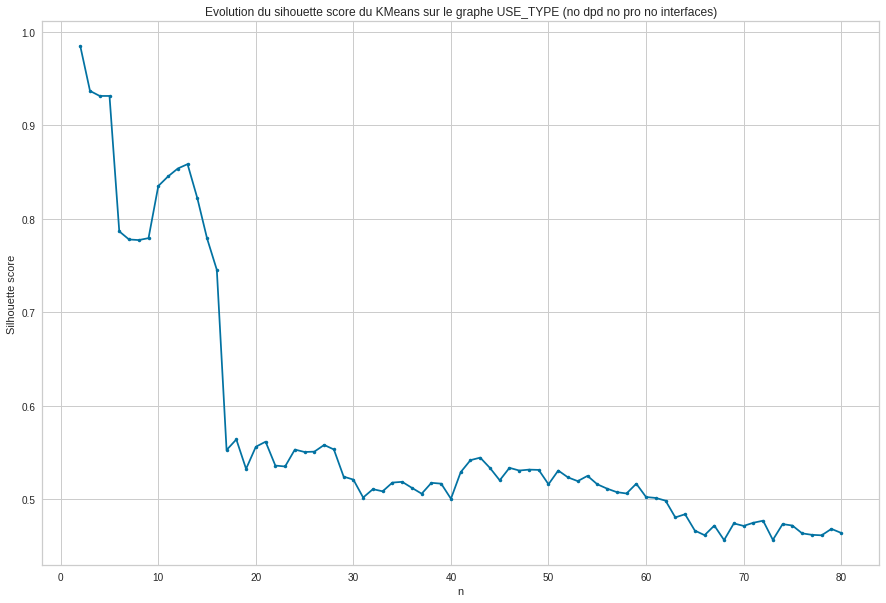

In [32]:
offset_left = 0
offset_right = 0
plt.plot(range(2+offset_left,max_k-offset_right), avg_silh[offset_left:(-offset_right if offset_right>0 else nbnoeuds)], marker=".")
plt.xlabel("n")
plt.ylabel("Silhouette score")
plt.title(f"Evolution du sihouette score du KMeans sur le graphe {relType} {get_graph_info(offset_left,offset_right)}")

#plt.savefig(f"silh{graph_suffix}.png")

#### Allure du silhouette score pour chaque noeud 

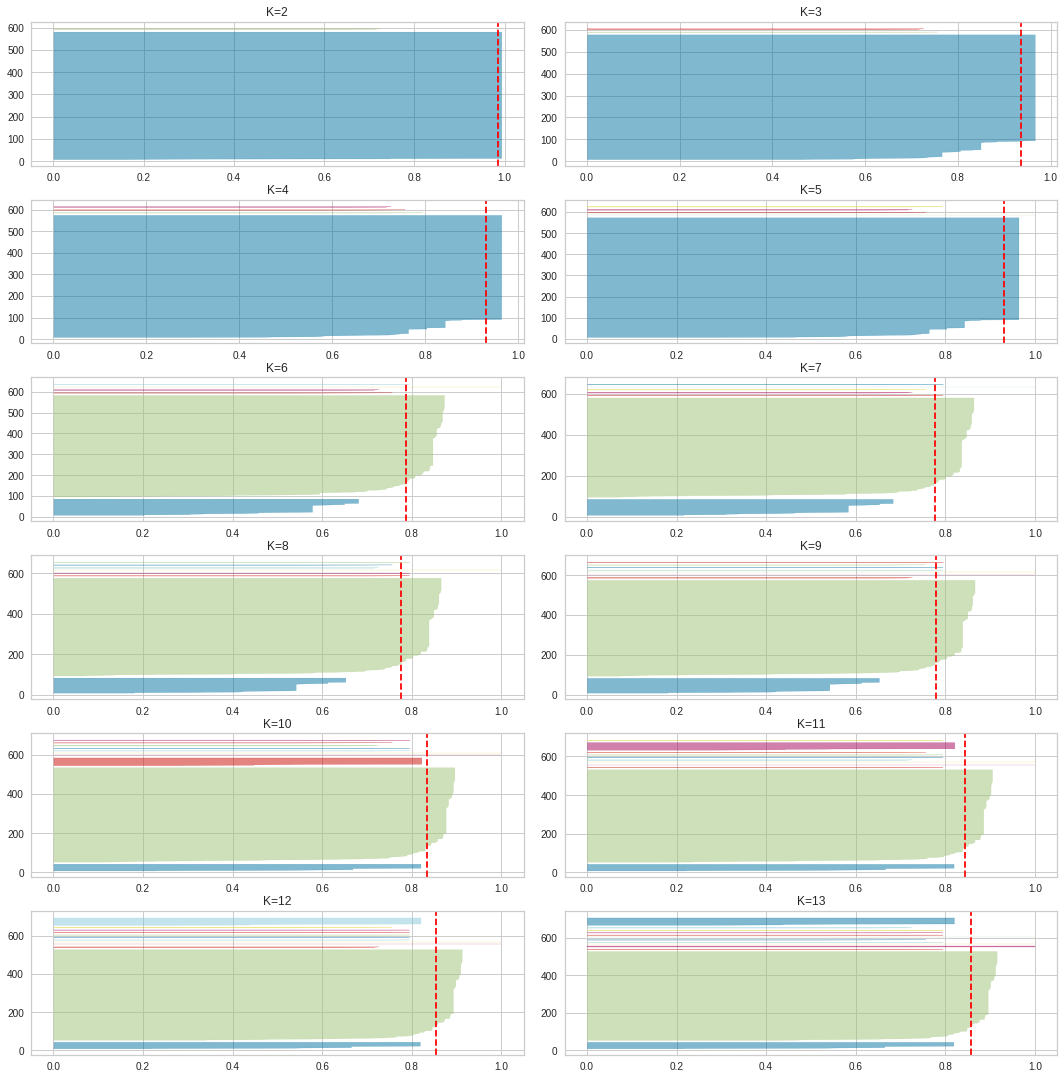

In [33]:
lower_i, upper_i = 2, 13

fig, ax = plt.subplots(6, 2, figsize=(15,15))
fig.tight_layout()
for i in range(lower_i, upper_i+1):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    ax[q-1, mod].set_title(f"K={i}")
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1, mod])
    visualizer.fit(vectp_norm[:,:i])

### Affichage des valeurs propres

In [35]:
firstk = min(60, nbnoeuds)

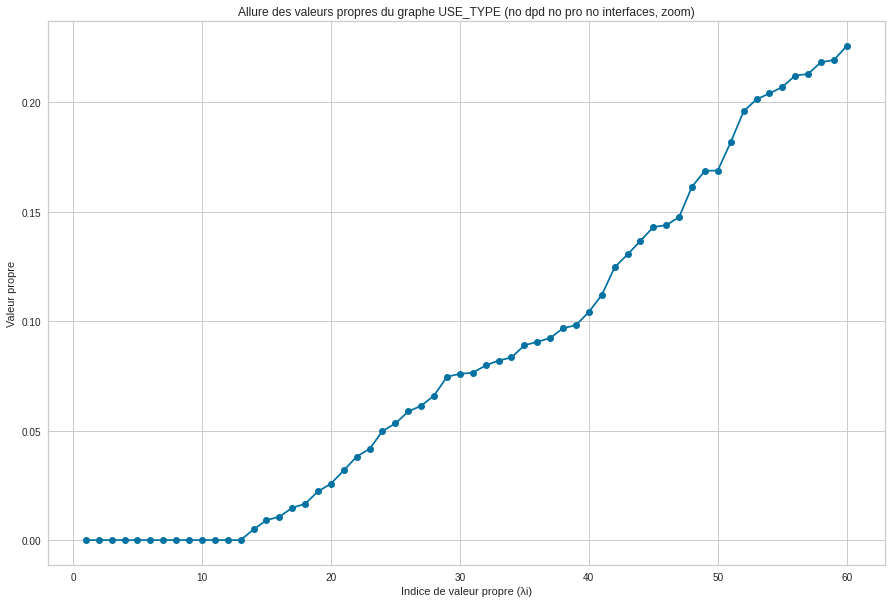

In [36]:
plt.title(f"Allure des valeurs propres du graphe {relType} {get_graph_info(0,nbnoeuds-firstk)}")
plt.xlabel('Indice de valeur propre (λi)')
plt.ylabel('Valeur propre')
#plt.set_title('Allure des valeurs propres du graphe')
#ax[0].plot(list(range(1,nbnoeuds+1)), list(map(abs,vp_norm)), marker="o")
plt.plot(range(1,firstk+1), list(map(abs,vp_norm[:firstk])), marker="o")

#Sauvegarde de la figure
#plt.savefig(f"VP{graph_suffix}{"zoom" if firstk<nbnoeuds else ""}.png")

#### Allure des valeurs propres + répartition

[]

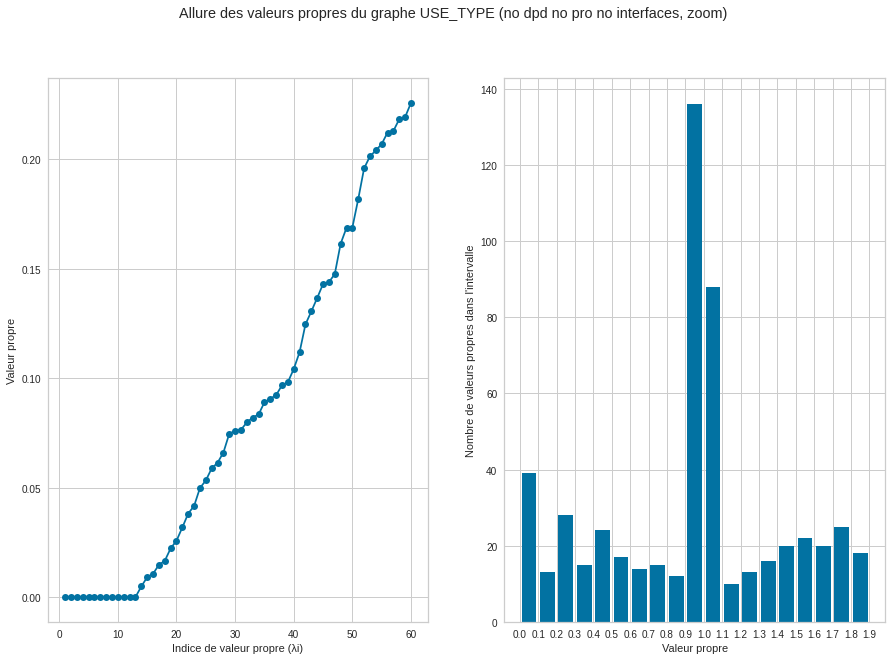

In [37]:
fig, ax = plt.subplots(1,2)
fig.suptitle(f"Allure des valeurs propres du graphe {relType} {get_graph_info(0,nbnoeuds-firstk)}")
ax[0].set_xlabel('Indice de valeur propre (λi)')
ax[0].set_ylabel('Valeur propre')
#plt.set_title('Allure des valeurs propres du graphe')
#ax[0].plot(list(range(1,nbnoeuds+1)), list(map(abs,vp_norm)), marker="o")
ax[0].plot(range(1,firstk+1), list(map(abs,vp_norm[:firstk])), marker="o")

bins = [0.1*i for i in range(20)]

ax[1].hist(list(map(abs,vp_norm)), bins, histtype='bar',rwidth=0.8)
ax[1].set_xlabel('Valeur propre')
ax[1].set_ylabel('Nombre de valeurs propres dans l\'intervalle')
ax[1].set_xticks(bins)

ax[1].plot()

#Sauvegarde de la figure
#fig.savefig(f"VPInfo{graph_suffix}{"zoom" if firstk<nbnoeuds else ""}.png")

#### Allure des vecteurs propres liés aux premières valeurs propres 

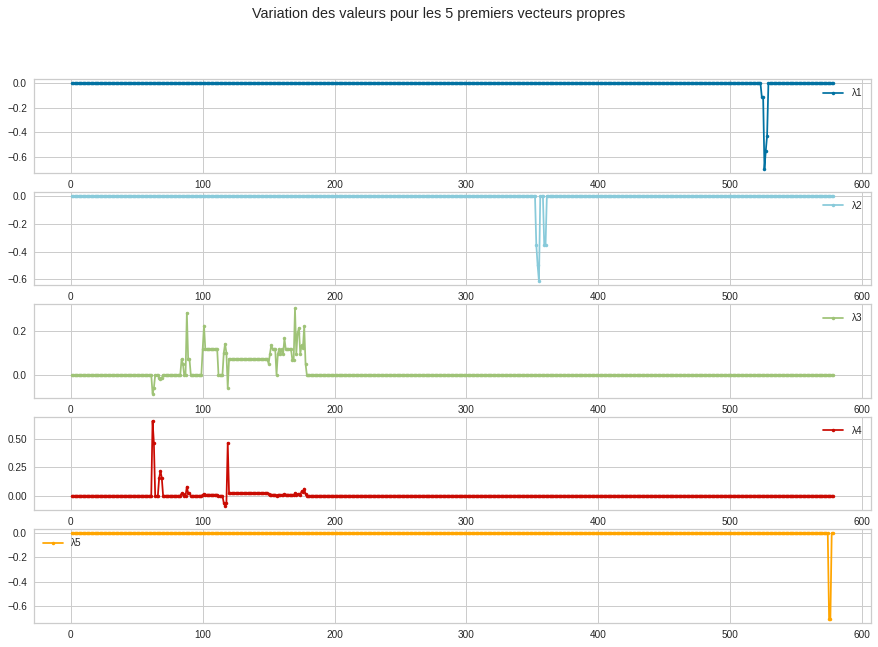

In [38]:
fig, ax = plt.subplots(5)
for k in range(5):
    colors = ['b','c','g','r','orange']
    fig.suptitle("Variation des valeurs pour les 5 premiers vecteurs propres")
    ax[k].plot(list(range(1,nbnoeuds+1)),vectp_norm[:,k], label=f'λ{k+1}', color=colors[k], marker=".")
    ax[k].legend()

### Plot 3D des vecteurs propres

In [39]:
pca = PCA(n_components=3)
L_3D = pca.fit_transform(L)

<IPython.core.display.Javascript object>


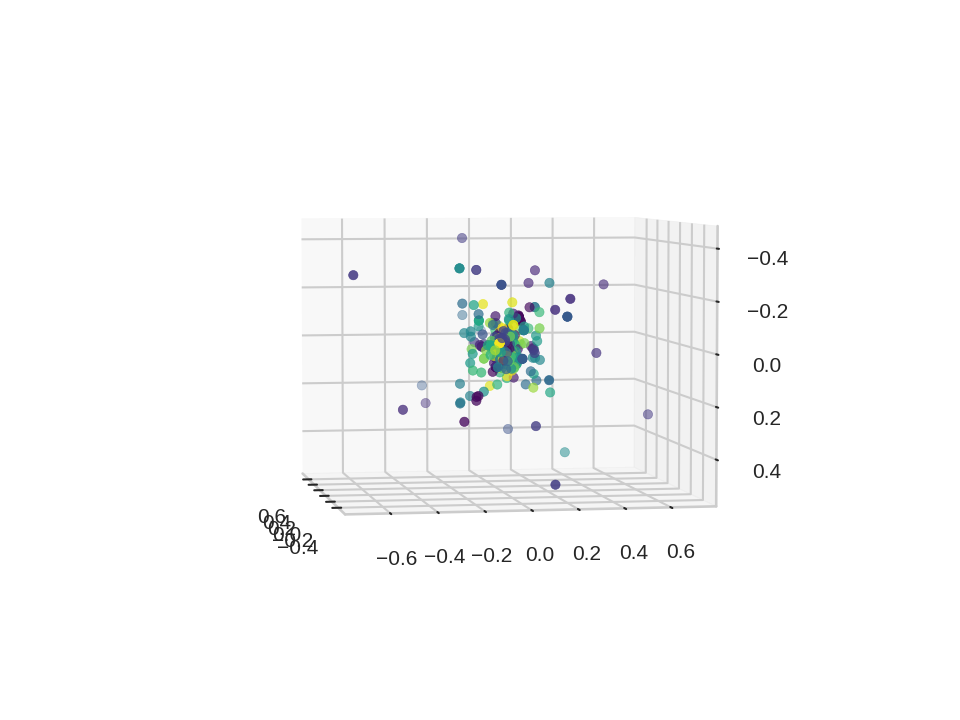

In [41]:
%matplotlib notebook


fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.scatter(L_3D[:,0], L_3D[:,1], L_3D[:,2], cmap="viridis", c=kmeans.labels_)

# Génération de graphes pour la visualisation des clusters

In [24]:
def graphViz(k, nodeType="Node", relType="LINKED_TO", version="V1", use_weights=False):
    """
    Crée le script d'un graphe permettant de visualiser les différents clusters donnés 
    par le partitionnement spectral
    """
    kmeans = KMeans(n_clusters=k).fit(vectp_norm[:,:k])
    
    with open(f"{relType}{version}{str_weight}_{k}.cypher","w") as out:
        #Récupération des ids et noms de tous les noeuds
        nodeQuery = f"""
        {query_start(same_ns=type_same_ns)} RETURN DISTINCT ID(n1) AS idNode, n1.{q_name()} AS nodeName
        """
        nodes = session.run(nodeQuery)


        for i,node in enumerate(nodes):
            idNode, nodeName = new_node_id(node["idNode"]), node["nodeName"]
            cluster_label = kmeans.labels_[idNode]
            #print(idNode+1,kmeans.labels_[idNode]+1)
            
            #Chaque noeud a pour type le label du cluster qui lui a été attribué par le KMeans
            out.write(f'CREATE (n{idNode+1}:Cluster{cluster_label+1}{{name:"{nodeName}"}})\n')

        relationQuery = f"""
        {query_start("r",type_same_ns)} RETURN ID(n1) AS id1, ID(n2) AS id2, TOINTEGER(r.{q_poids()}) AS poids, r.optional as opt
        """
        relations = session.run(relationQuery)

        #On recrée les relations entre les noeuds
        for relation in relations:
            id1, id2 = new_node_id(relation["id1"]), new_node_id(relation["id2"])
            cluster_label = kmeans.labels_[id1]
            #print(id1+1, id2+1)
            if relType in {"USE_NS","USE_TYPE"} and use_weights:
                w = (relation["poids"]*(0.1 if relation["opt"] == "yes" else 1)+1)/(max_poids+1)
                out.write(f'CREATE (n{id1+1})-[:{relType}{{poids:{round(w,3)}}}]->(n{id2+1})\n')
            else:
                out.write(f'CREATE (n{id1+1})-[:{relType}]->(n{id2+1})\n')
        out.write(";")

In [25]:
def graphVizAbstract(k, nodeType="Node", relType="LINKED_TO", version="V1", use_weights=False):
    """
    Crée le script d'un graphe pour visualiser le clustering obtenu 
    avec le partitionnement spectral de manière plus abstraite
    """
    
    names_per_cluster = {i+1:[] for i in range(k)}
    A_k = np.zeros((k,k))
    id_counter = 0
    
    kmeans = KMeans(n_clusters=k).fit(vectp_norm[:,:k])
    
    with open(f"{relType}Abs{version}{str_weight}_{k}.cypher","w") as out:
        #Récupération des ids et noms de tous les noeuds
        nodeQuery = f'{query_start(same_ns=type_same_ns)} RETURN DISTINCT ID(n1) AS idNode, n1.{q_name()} AS nodeName'
        nodes = session.run(nodeQuery)
        
        for node in nodes:
            idNode, nodeName = new_node_id(node["idNode"]), node["nodeName"]
            label = kmeans.labels_[idNode]
            names_per_cluster[label+1].append(nodeName)

        #Récupération des relations avec leur poids et son optionalité si présents
        relationQuery = f"""
        {query_start("r",type_same_ns)} RETURN ID(n1) AS id1, ID(n2) AS id2, TOINTEGER(r.{q_poids()}) AS poids, r.optional as opt
        """
        relations = session.run(relationQuery)

        #Calcul de la matrice d'adjacence entre clusters
        for relation in relations:
            id1, id2 = new_node_id(relation["id1"]), new_node_id(relation["id2"])
            label1, label2 = kmeans.labels_[id1], kmeans.labels_[id2]
            if label1 != label2: #On ne compte que les relations entre noeuds de clusters différents
                if relType in {"USE_NS","USE_TYPE"} and use_weights:
                    A_k[label1,label2] += (relation["poids"]*(0.1 if relation['opt'] == "yes" else 1)+1)/(max_poids+1)
                else:
                    A_k[label1,label2] += 1

        #Création des noeuds
        for i in range(k):
            out.write(f'CREATE (n{i+1}:Cluster{i+1}{{name:"C{i+1}",names:{names_per_cluster[i+1]}, nbNoeuds:{len(names_per_cluster[i+1])}}})\n')

        #Création des relations entre clusters
        for ci,cluster in enumerate(A_k):
            for i,w in enumerate(cluster):
                #print(i+1, w)
                if w != 0:
                    out.write(f'CREATE (n{ci+1})-[:{relType}{{poids:{round(w,3)}}}]->(n{i+1})\n')

        out.write(";")
        #print(A_k)
        #print(names_per_cluster)
    

In [26]:
k = 13

In [28]:
graphViz(k, nodeType, relType, version, use_weights)

In [29]:
graphVizAbstract(k,nodeType, relType, version, use_weights)

------------------------